In [1]:
import numpy as np

# xarray is used to read and plot the downloaded NetCDF files
import xarray as xr
import netCDF4
import sys

import matplotlib.pyplot as plt
import glob, os

import metpy, pint

from global_land_mask import globe


In [2]:
import numpy as np
import pandas as pd
import requests
import shutil
import time as time
from os.path import join,expanduser
user_home_dir = expanduser('~')

# xarray is used to read and plot the downloaded NetCDF files
import xarray as xr
import sys

import matplotlib.pyplot as plt

# for concurrent simultaneous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import basename, isfile, isdir
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request

import glob, os

# Predict the path of the netrc file depending on os/platform type.
_netrc = join(user_home_dir, "_netrc" if system()=="Windows" else ".netrc")

# load the ecco_v4_py package
# here is is assumed to be installed in /home/user/ECCOv4-py
# change as needed for your setup
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

# from ecco_v4_py import *

GEBCO resolution is 15 arc second, which equates to about 500m at the equator.

We, at most, would care about resolution on the order of the deformation radius, which
has a minimum around 10km.

Let's (1) smooth the topo data, then (2) interpolate onto coarse grid.
Eventually we can set the coarse grid resolution to align with ECCOv4 resolution.

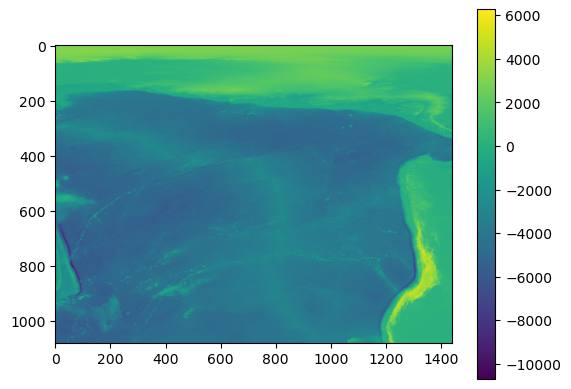

In [3]:
gebco_dir = "/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/GEBCO_07_Feb_2025_2fae42747dd8"

os.chdir(gebco_dir)
gebco_file = glob.glob("*.nc")  # order is 
gebco_file = 'gebco_2024_n0.0_s-90.0_w-180.0_e-60.0.nc';

gebco = xr.open_dataset(gebco_file, engine="netcdf4")

im1 = plt.imshow(gebco.elevation.values[::20,::20])
plt.colorbar(im1)

In [4]:
def conv_2D_wrap(arr, filt):
    arr_out = np.copy(arr)
    half_width = int(np.ceil(np.shape(filt)[0]/2))

    arr_ext = np.vstack((arr[-half_width:,:],arr,arr[0:half_width,:]))
    arr_ext = np.hstack((arr_ext[:,-half_width:],arr_ext,arr_ext[:,0:half_width]))
    # arr_ext = np.hstack((np.flip(arr_ext[:,0:half_width],axis=1),arr_ext,np.flip(arr_ext[:,-half_width:],axis=1)))
    
    for i in np.arange(0, np.shape(arr)[0]):
        for j in np.arange(0, np.shape(arr)[1]):
            arr_out[i,j] = np.sum(filt * arr_ext[i:i+2*half_width-1,j:j+2*half_width-1])

    # dealing with edges
    return arr_out

def conv_2D(arr, filt):
    arr_out = np.copy(arr)
    half_width = int(np.ceil(np.shape(filt)[0]/2))

    arr_ext = np.vstack(( np.ones((half_width,1)) * arr[0,:].reshape(1,len(arr[0,:])),arr, np.ones((half_width,1)) * arr[-1,:].reshape(1,len(arr[-1,:]))))
    
    arr_ext = np.hstack((arr_ext[:,0].reshape(len(arr_ext[:,0]),1) * np.ones((1,half_width)),arr_ext, arr_ext[:,-1].reshape(len(arr_ext[:,-1]),1) * np.ones((1,half_width))))
        
    for i in np.arange(0, np.shape(arr)[0]):
        print('Convolving row ' + str(i) + ' out of ' + str(np.shape(arr)[0]))
        for j in np.arange(0, np.shape(arr)[1]):
            arr_out[i,j] = np.sum(filt * arr_ext[i:i+2*half_width-1,j:j+2*half_width-1])

    # dealing with edges
    return arr_out
            
            
def twoD_Gauss(nx,ny,sigmax,sigmay):
    x = np.arange(-nx,nx+1)
    y = np.arange(-ny,ny+1)
    X,Y = np.meshgrid(x,y)
    g = np.exp(- X**2 / (2 * sigmax**2) - Y**2 / (2 * sigmay**2))

    return g / np.sum(g)

# a function to smooth and down sample GEBCO data
def GEBCO_load(filename, ds_factor, filt_width, filt_ds):

    gebco = xr.open_dataset(filename, engine="netcdf4")
    
    print('done merging')
    
    fil = twoD_Gauss(filt_width, filt_width, np.floor(0.5*filt_width).astype(int), np.floor(0.5*filt_width).astype(int))
    hbottom = conv_2D(gebco.elevation.values[::filt_ds, ::filt_ds], fil)  # convolve downsamples by filt_ds

    ds_out = xr.Dataset(
    data_vars=dict(
        elevation=(["lat", "lon"], hbottom),
    ),
    coords=dict(
        lon=("lon", gebco.lon.data[::filt_ds]),
        lat=("lat", gebco.lat.data[::filt_ds]),
    ),
    attrs=dict(description="topography data"),
    )

    return fil, ds_out.elevation[::ds_factor, ::ds_factor] # hbottom[::ds_output, ::ds_output]  # gebco.elevation[::ds_factor, ::ds_factor] # 


def GEBCO_load_all(filenames, filt_ds, filt_width, ds_factor):
    # ds_factor: this is how much we downsample the filtered data (only used on return line)
    # filt_width: this nx, ny of Gaussian filter used on data that is already downsampled by filt_ds
    # filt_ds: this is INITIAL DOWNSAMPLE FACTOR, i.e., when we load the data before filtering
    
    for filename in filenames:
        if filename==filenames[0]:
            gebco = xr.open_dataset(filename, engine="netcdf4").elevation[::filt_ds, ::filt_ds]
        else:
            gebco = xr.merge([gebco, xr.open_dataset(filename, engine="netcdf4").elevation[::filt_ds, ::filt_ds]])

    print('done merging')
    
    fil = twoD_Gauss(filt_width, filt_width, np.floor(0.5*filt_width).astype(int), np.floor(0.5*filt_width).astype(int))
    hsmooth = conv_2D(gebco.elevation.values, fil)  # convolve downsamples by filt_ds

    hrough = gebco.elevation.values - hsmooth

    ds_out = xr.Dataset(
    data_vars=dict(
        smooth_elevation=(["lat", "lon"], hsmooth),
        rough_elevation=(["lat", "lon"], hrough),
    ),
    coords=dict(
        lon=("lon", gebco.lon.data),
        lat=("lat", gebco.lat.data),
    ),
    attrs=dict(description="topography data"),
    )

    return fil, ds_out

In [7]:
gebco_dir = "/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/GEBCO_07_Feb_2025_2fae42747dd8"

os.chdir(gebco_dir)
gebco_file = glob.glob("*.nc")  # order is SW, SM, NM, NW, NE, SE

# initial data has 15 arc-second (~0.0042 degree) resolution
# If we want to resolve topo at about 1 cycle/km, then we want a resolution
# of 0.1 km, about. Where 0.1km ~ 0.001 degreee; so we need to keep all
# topo data and are still under-resolving topo ugh; this is too limiting
# If instead we stick to ``mesoscale'' topography, we want to resolve O(10km) topo,
# leading to 1km ish resolution, so we can downsample by factor of 5.

ds_factor = 1 #
filt_width = 50   # total width of Gaussian filter; this is after initial filt_ds downsample; 250 is about one degree with native GEBCO resolution
filt_ds = 5


# filt, SW_topo = GEBCO_load(gebco_file[0], ds_factor, filt_width, filt_ds)
# print('a')
# filt, SM_topo = GEBCO_load(gebco_file[1], ds_factor, filt_width, filt_ds)
# print('b')
# filt, NM_topo = GEBCO_load(gebco_file[2], ds_factor, filt_width, filt_ds)
# print('c')
# filt, NW_topo = GEBCO_load(gebco_file[3], ds_factor, filt_width, filt_ds)
# print('d')
# filt, NE_topo = GEBCO_load(gebco_file[4], ds_factor, filt_width, filt_ds)
# print('e')
# filt, SE_topo = GEBCO_load(gebco_file[5], ds_factor, filt_width, filt_ds)

filt, global_topo = GEBCO_load_all(gebco_file, filt_ds, filt_width, ds_factor)

# with filt_ds=5, script takes about 7 minutes to start printing progress


done merging
Convolving row 0 out of 8640
Convolving row 1 out of 8640
Convolving row 2 out of 8640
Convolving row 3 out of 8640
Convolving row 4 out of 8640
Convolving row 5 out of 8640
Convolving row 6 out of 8640
Convolving row 7 out of 8640
Convolving row 8 out of 8640
Convolving row 9 out of 8640
Convolving row 10 out of 8640
Convolving row 11 out of 8640
Convolving row 12 out of 8640
Convolving row 13 out of 8640
Convolving row 14 out of 8640
Convolving row 15 out of 8640
Convolving row 16 out of 8640
Convolving row 17 out of 8640
Convolving row 18 out of 8640
Convolving row 19 out of 8640
Convolving row 20 out of 8640
Convolving row 21 out of 8640
Convolving row 22 out of 8640
Convolving row 23 out of 8640
Convolving row 24 out of 8640
Convolving row 25 out of 8640
Convolving row 26 out of 8640
Convolving row 27 out of 8640
Convolving row 28 out of 8640
Convolving row 29 out of 8640
Convolving row 30 out of 8640
Convolving row 31 out of 8640
Convolving row 32 out of 8640
Convolv

In [8]:
# saving first version of topo data, just to avoid having to re-run

# pc1 = plt.pcolormesh(filt)
# plt.colorbar(pc1)

# plt.figure()

# plt.plot(filt[np.round(len(filt[0,:])/2).astype(int),:])

# plt.pcolormesh(NE_topo.data)


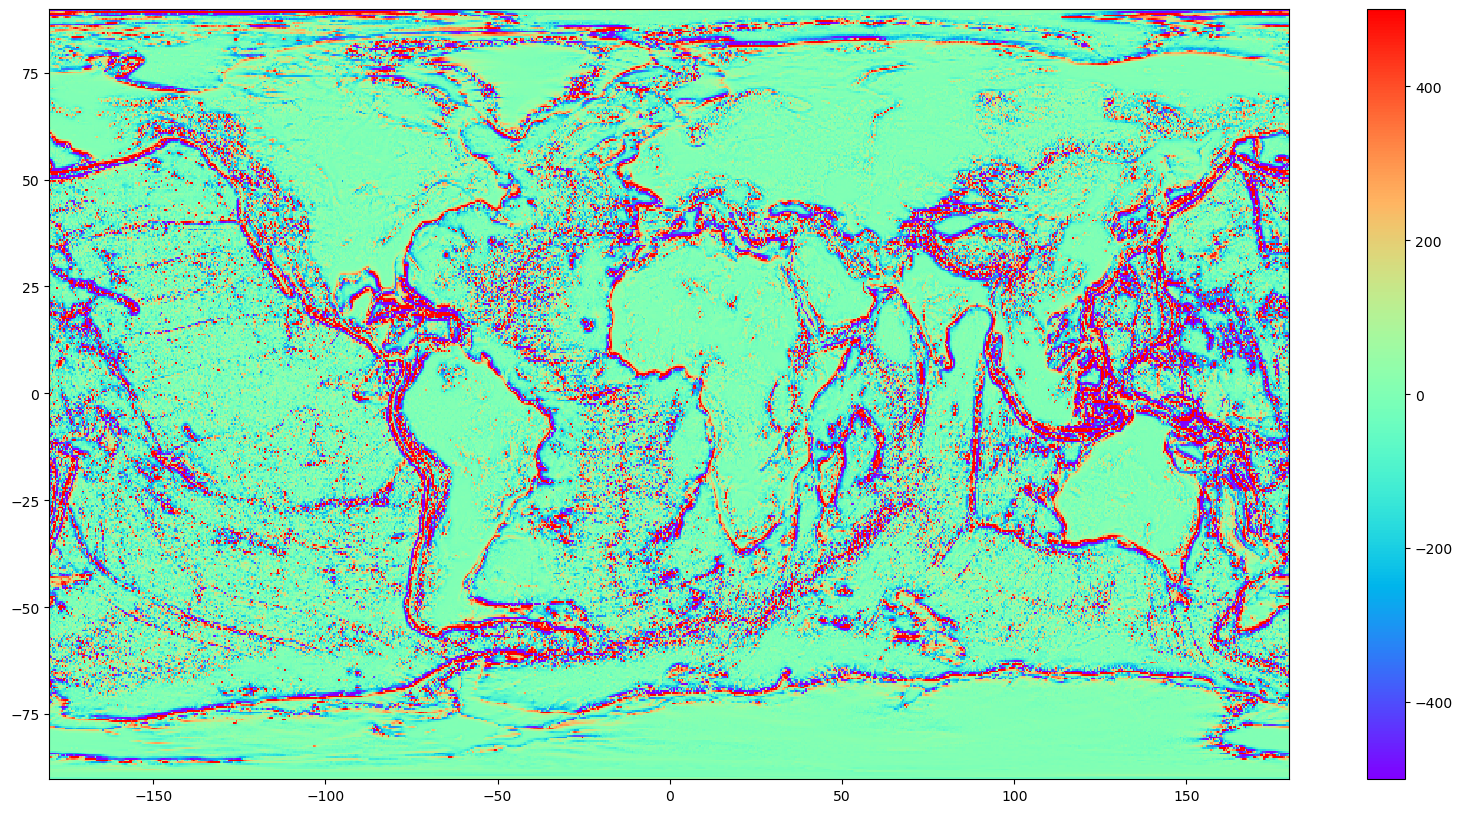

In [23]:
# # merging data arrays
# global_topo = xr.merge([SW_topo, SM_topo, SE_topo, NW_topo, NM_topo, NE_topo])

# dir_path = '/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/'
# global_topo.to_netcdf(path=dir_path + 'global_topo_unmerged_ds2_fw23_fds15.nc')

# global_topo = xr.open_dataset(dir_path + 'global_topo_unmerged_ds5_fw21_fds_4.nc', engine="netcdf4")
fig, ax = plt.subplots(1,1, figsize=(20,10))

lat = global_topo.smooth_elevation.lat
lon = global_topo.smooth_elevation.lon

lim = 500

# pc1 = ax.pcolormesh(lon[300:1260], lat[300:1260], global_topo.rough_elevation.data[300:1260, 300:1260], vmin=-lim, vmax=lim, cmap=plt.get_cmap('rainbow'))
pc1 = ax.pcolormesh(lon[::20], lat[::20], global_topo.rough_elevation.data[::20, ::20], vmin=-lim, vmax=lim, cmap=plt.get_cmap('rainbow'))


# ax.set_xlim(-175,-125)
# ax.set_ylim(-75,-50)

plt.colorbar(pc1)

In [32]:
# defining land mask
        
# land_mask = np.zeros((global_topo.lat.shape[0], global_topo.lon.shape[0]))

# for i in np.arange(0, global_topo.lat.shape[0]):
#     print('Masking row ' + str(i) + ' out of ' + str(global_topo.lat.shape[0]))
#     for j in np.arange(0, global_topo.lon.shape[0]):
#         # print(i); print(' and '); print(j, end='\r')
#         land_mask[i,j] = globe.is_land(global_topo.lat[i], global_topo.lon[j])

lat = global_topo.smooth_elevation.lat
lon = global_topo.smooth_elevation.lon

lon, lat = np.meshgrid(lon, lat)

land_mask=~globe.is_land(lat,lon)



In [40]:
# calculate bathymetry gradient
# metpy.calc.geospatial_gradient(gebco.elevation.values[::20,::20], latitude=pint.Quantity(gebco.lat.values[::20]), longitude=pint.Quantity(gebco.lon.values[::20]))

# detab_dx, detab_dy = metpy.calc.geospatial_gradient(global_topo)
# global_topo

# global_topo = global_topo.to_dataset()

In [41]:
# apply land mask

# elev_masked = global_topo.elevation.values * np.abs(land_mask-1)

# global_topo.assign(dict(elevation_masked=(["lat", "lon"], elev_masked)))

elev_masked = global_topo.elevation.values * np.abs(land_mask-1)

global_topo.assign(dict(elevation_masked=(["lat", "lon"], elev_masked)))



<xarray.Dataset> Size: 7MB
Dimensions:           (lon: 1080, lat: 540)
Coordinates:
  * lon               (lon) float64 9kB -180.0 -179.7 -179.3 ... 179.3 179.7
  * lat               (lat) float64 4kB -90.0 -89.66 -89.33 ... 89.0 89.34 89.67
Data variables:
    elevation         (lat, lon) float32 2MB 2.88e+03 2.88e+03 ... -3.634e+03
    elevation_masked  (lat, lon) float64 5MB 0.0 0.0 ... -3.633e+03 -3.634e+03

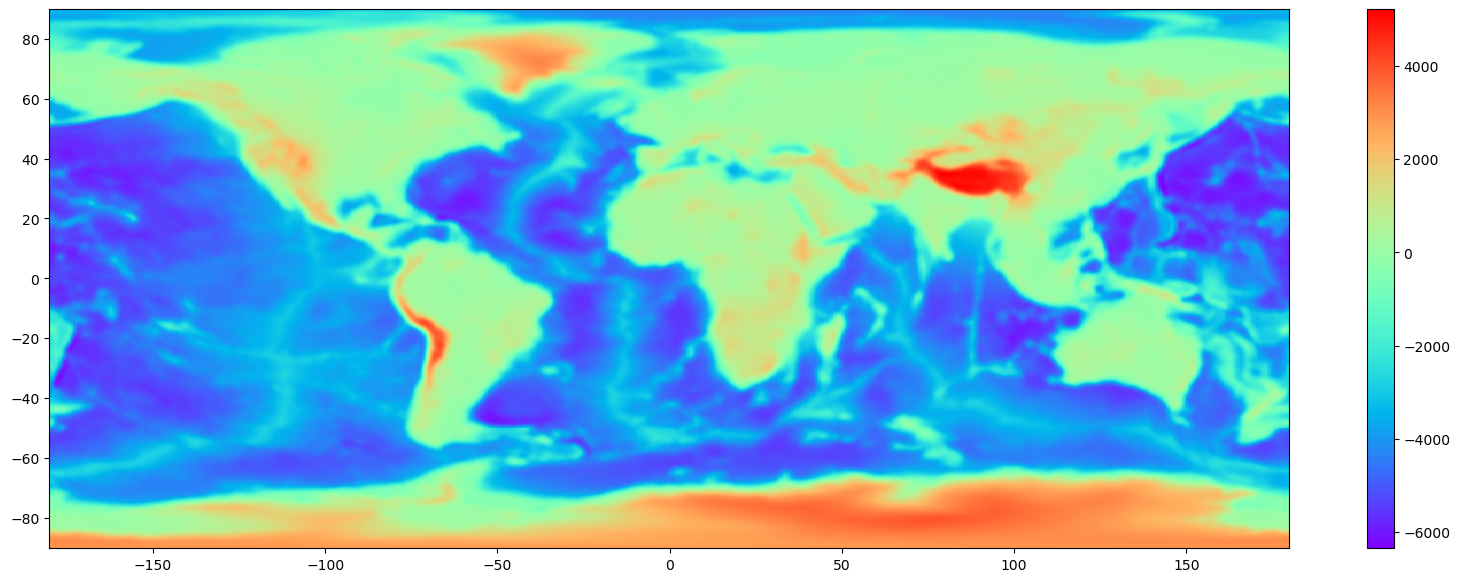

In [42]:
from matplotlib.colors import LogNorm

grad_mag = np.sqrt(detab_dx**2 + detab_dy**2)

eps=1e-4
# Create pcolormesh with log scale
lat = global_topo.elevation.lat
lon = global_topo.elevation.lon
# dlat = 0.5 * (lat[0:-1] + lat[1:])
# dlon = 0.5 * (lon[0:-1] + lon[1:])

fig, ax = plt.subplots(1,1, figsize=(20,7))

# pc1 = plt.pcolormesh(lon, lat, grad_mag, norm=LogNorm(vmin=eps, vmax=0.05), shading='auto', cmap=plt.get_cmap('rainbow'))
pc1 = plt.pcolormesh(lon, lat, global_topo.elevation.data, shading='auto', cmap=plt.get_cmap('rainbow'))

plt.colorbar(pc1)

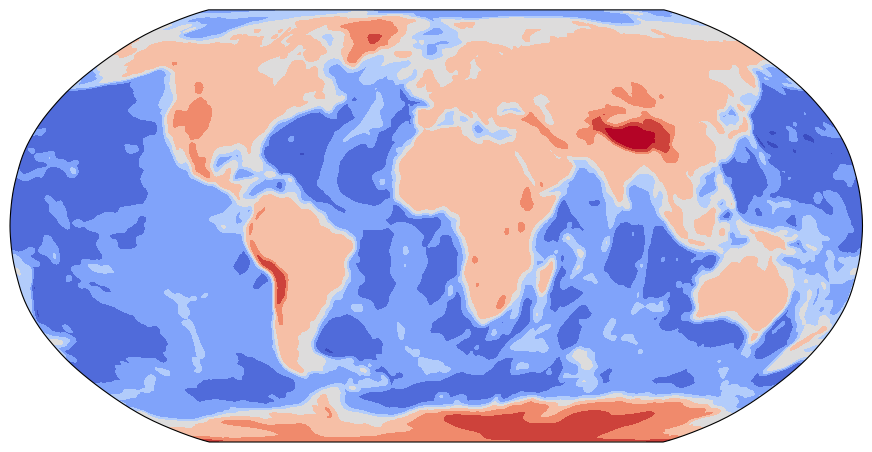

In [46]:
import warnings

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.Robinson())

# Add cyclic point to data
data= global_topo.elevation.data
data, lons = add_cyclic_point(data, coord=global_topo.elevation.lon)


# Make a filled contour plot
cs=ax.contourf(lons, global_topo.elevation.lat, data,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')


# THanks tp https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html

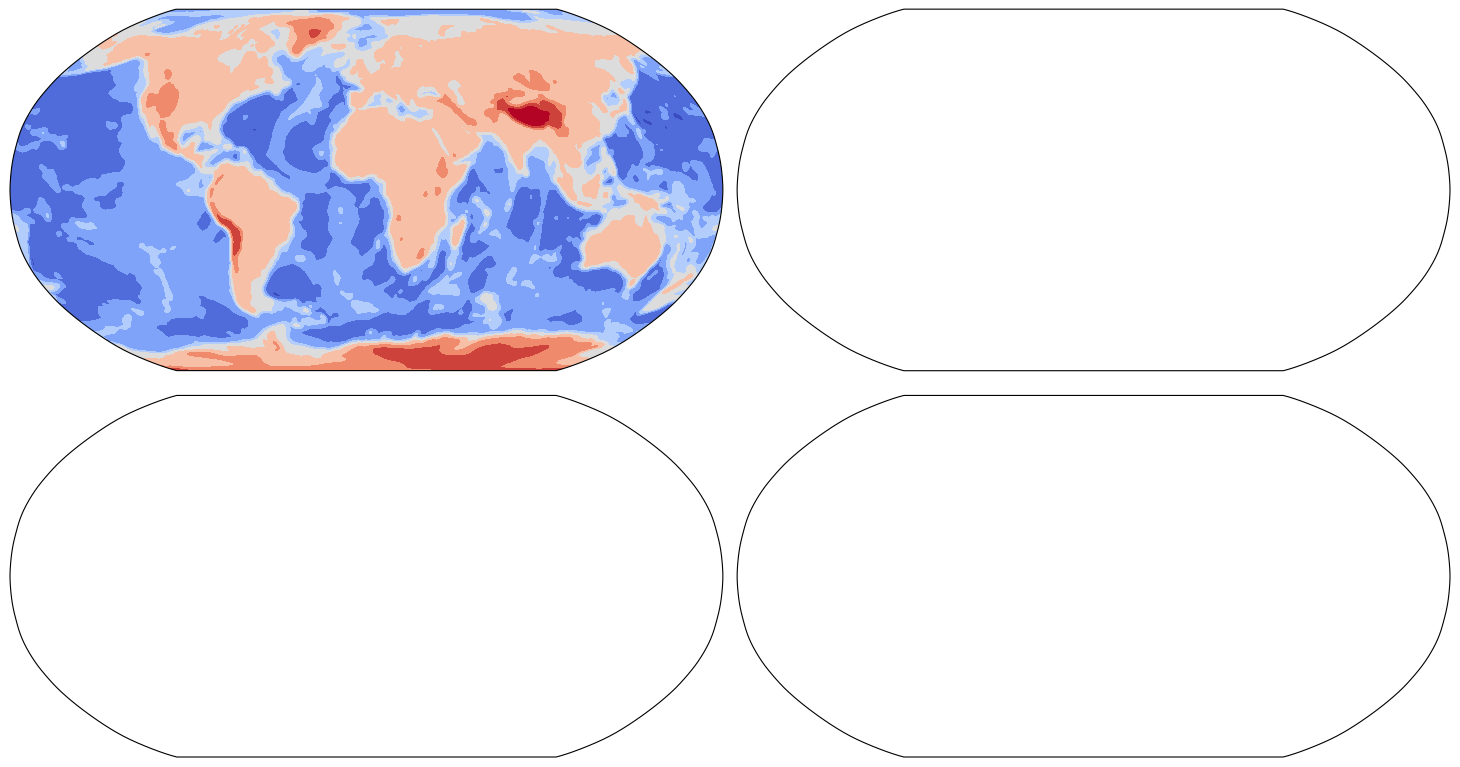

In [56]:
# # add land mask and seafloor gradient to data array
# global_topo.assign(landmask=land_mask)

# global_topo.assign(detabdx=detab_dx)
# global_topo.assign(detabdy=detab_dy)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(16,8.5))

fig.tight_layout(pad=0.0)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

axs[0].contourf(lons, global_topo.elevation.lat, data,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.95,
                    wspace=0.02, hspace=0.02)

In [143]:
# # write data array to nc
# dir_path = '/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/'
# global_topo.to_netcdf(path=dir_path + 'global_topo_ds40.nc')
# calc_ds.to_netcdf(path=dir_path + 'calc_ds40.nc')




In [142]:
# calc_ds = xr.Dataset(
#     data_vars=dict(
#         elevation_masked=(["lat", "lon"], elev_masked),
#         land_mask=(["lat", "lon"], land_mask),
#         detab_dx=(["lat", "lon"], detab_dx),
#         detab_dy=(["lat", "lon"], detab_dy),
#     ),
#     coords=dict(
#         lon=("lon", lon.data),
#         lat=("lat", lat.data),
#     ),
#     attrs=dict(description="topography data"),
# )

In [34]:
# global_topo = global_topo.assign(dict(elevation_masked=(["lat", "lon"], elev_masked)))

global_topo = global_topo.assign(dict(land_mask=(["lat", "lon"], land_mask)))

# global_topo = global_topo.assign(dict(detab_dx=(["lat", "lon"], detab_dx)))

# global_topo = global_topo.assign(dict(detab_dy=(["lat", "lon"], detab_dy)))


In [39]:
dir_path = '/scratch/cimes/ml1994/global_topo_analysis/data/data_topo/'
file_name = 'global_topo_merged_masked_smooth_rough_decomp_ds1_fw50_fds5.nc'

# global_topo.to_netcdf(path=dir_path + file_name)


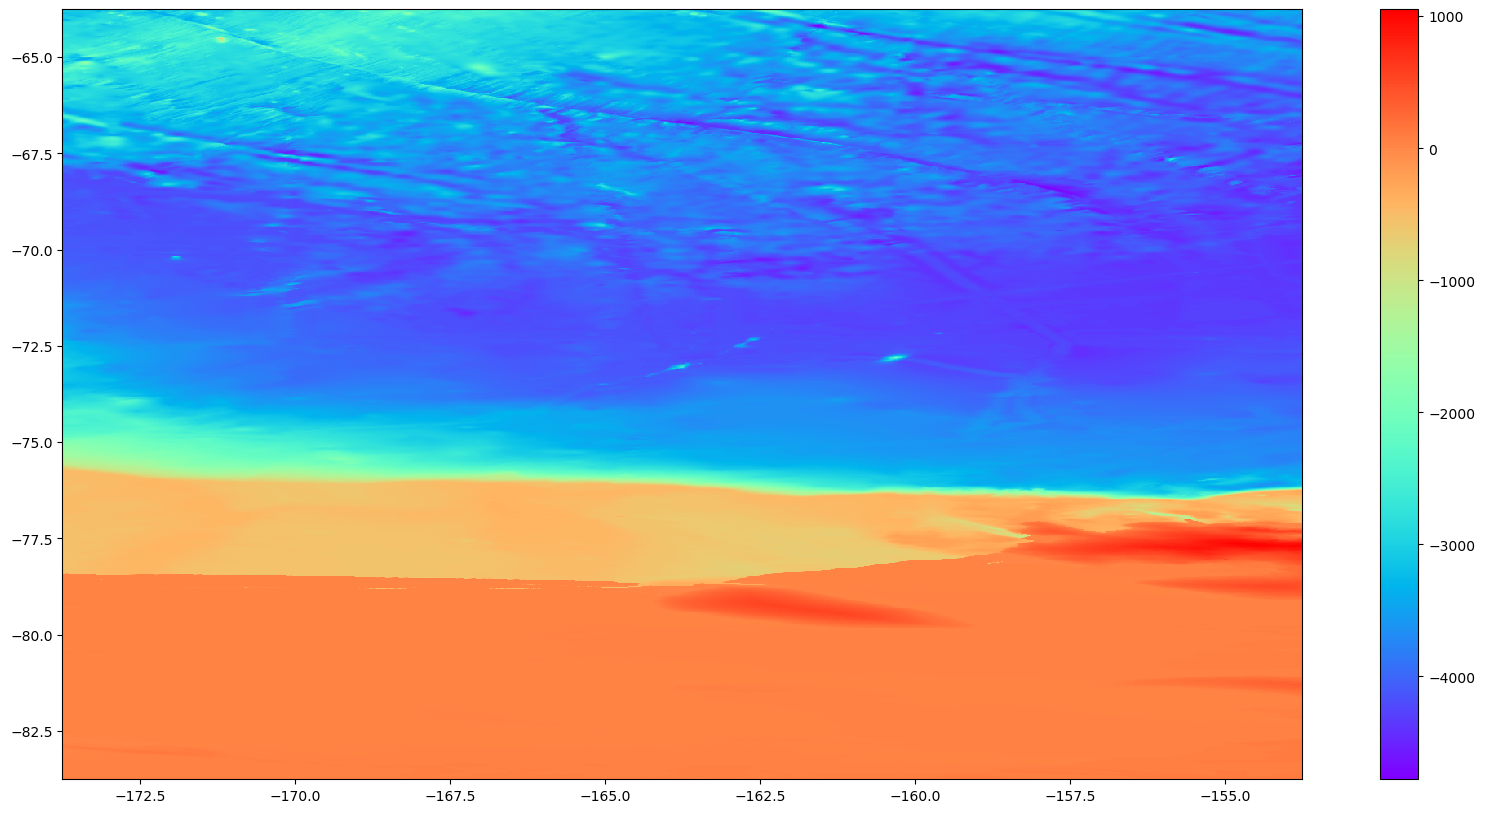

In [49]:
global_topo = xr.open_dataset(dir_path + file_name, engine="netcdf4")

fig, ax = plt.subplots(1,1, figsize=(20,10))

lat = global_topo.smooth_elevation.lat
lon = global_topo.smooth_elevation.lon

# lon, lat = np.meshgrid(lon, lat)


lim = 500

pc1 = ax.pcolormesh(lon[300:1260], lat[300:1260], global_topo.rough_elevation.data[300:1260, 300:1260] + global_topo.smooth_elevation.data[300:1260, 300:1260], cmap=plt.get_cmap('rainbow'))

# pc1 = ax.pcolormesh(lon[300:1260], lat[300:1260], global_topo.smooth_elevation.data[300:1260, 300:1260], cmap=plt.get_cmap('rainbow'))

# pc1 = ax.pcolormesh(lon, lat, global_topo.rough_elevation.data * global_topo.land_mask.data, vmin=-lim, vmax=lim, cmap=plt.get_cmap('rainbow'))


# ax.set_xlim(-175,-125)
# ax.set_ylim(-75,-50)

plt.colorbar(pc1)